In [31]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from pydantic import BaseModel, Field
from typing import Optional, List, Any, Annotated
from langchain_core.language_models.llms import LLM
from openai import OpenAI
import operator
import json

In [39]:
class LightningLLM(LLM):
    def __init__(self, api_key: str, model: str, **kwargs):
        super().__init__(**kwargs)
        object.__setattr__(self, "client", OpenAI(base_url="https://lightning.ai/api/v1/", api_key=api_key))
        object.__setattr__(self, "model", model)

    def _call(self, prompt: str, stop: Optional[List[str]] = None, run_manager: Optional = None, **kwargs: Any) -> str:
        
        resp = self.client.chat.completions.create(
            model=self.model,
            messages=[{"role": "user", "content": [{"type": "text", "text": prompt}]}],
            temperature=0.1,
            max_tokens=2048 
        )
        return resp.choices[0].message.content

    def with_structured_output(self, schema: type[BaseModel]):
        def structured_call(user_input: str):
            schema_json = json.dumps(schema.model_json_schema(), indent=2)
            
            system_instruction = f"""
            You MUST output only valid JSON that strictly matches this schema:
            {schema_json}
            Rules:
            - Do NOT add explanations.
            - Do NOT add additional fields.
            - Output ONLY JSON.
            """
            
            full_prompt = f"{system_instruction}\nUser Query:\n{user_input}"
            raw_output = self._call(full_prompt)
            
            try:
                data = json.loads(raw_output)
            except:
                try:
                    json_part = raw_output[raw_output.find("{"):raw_output.rfind("}") + 1]
                    data = json.loads(json_part)
                except Exception as e:
                    raise ValueError(f"Model did not return valid JSON:\n{raw_output}") from e

            return schema(**data)
        return structured_call
    
    @property
    def _identifying_params(self):
        return {"model": self.model}

    @property
    def _llm_type(self):
        return "lightning_gpt"

In [ ]:
model = LightningLLM(api_key="API_KEY", model="google/gemini-2.5-flash")

In [9]:
class EvaluationSchema(BaseModel):
    feedback : str = Field(description="Detailed feedback for the essay")
    score : int = Field(description="Score out of 10", ge=0, le=10)

In [37]:
structured_model = model.with_structured_output(EvaluationSchema)

In [25]:
essay = """Artificial Intelligence (AI) has rapidly transformed from a futuristic concept into an essential part of everyday life. At its core, AI refers to the ability of machines to perform tasks that typically require human intelligence—such as learning, reasoning, problem-solving, perception, and language understanding. Over the past few decades, advancements in computing power, data availability, and algorithms have enabled AI systems to achieve remarkable capabilities, often surpassing human performance in specific domains.

One of the most significant impacts of AI is seen in automation. Industries such as manufacturing, logistics, healthcare, and finance now rely heavily on intelligent systems to optimize processes, reduce human error, and improve efficiency. For example, robots assemble products with precision, AI-powered diagnostic tools assist doctors in identifying diseases early, and predictive algorithms help financial institutions detect fraud. These innovations not only enhance productivity but also reshape the global workforce, leading to both opportunities and challenges regarding employment and skill development.

AI has also revolutionized the way people interact with technology. Virtual assistants, recommendation systems, and smart devices have become integral to daily routines. Platforms like YouTube, Netflix, and Spotify personalize content based on user behavior, while navigation apps use real-time data to suggest optimal routes. These conveniences highlight how deeply AI has integrated into modern lifestyles, often operating behind the scenes without users even realizing it."""

In [40]:
prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}'

structured_model(prompt).score

C:\Users\User\AppData\Local\Temp\ipykernel_9876\650810178.py:31: PydanticDeprecatedSince20: The `schema_json` method is deprecated; use `model_json_schema` and json.dumps instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  {schema.schema_json(indent=2)}


9

In [58]:
class EssayState(TypedDict):
    essay : str
    language_feedback : str
    analysis_feedback : str
    clarity_feedback : str
    overall_feedback : str
    individual_scores : Annotated[List[int], operator.add]
    avg_score : float

In [59]:
def eavluate_language(state : EssayState):
    prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model(prompt)
    
    return {"language_feedback" : output.feedback, "individual_scores" : [output.score]}

In [60]:
def eavluate_analysis(state : EssayState):
    prompt = f'Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model(prompt)
    
    return {"analysis_feedback" : output.feedback, "individual_scores" : [output.score]}

In [61]:
def eavluate_thought(state : EssayState):
    prompt = f'Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model(prompt)
    
    return {"clarity_feedback" : output.feedback, "individual_scores" : [output.score]}

In [62]:
def final_eavluation(state : EssayState):
    prompt = f'Based on the following feedbacks create a summarized feedback \n language feedback - {state["language_feedback"]} \n depth of analysis feedback - {state["analysis_feedback"]} \n clarity of thought feedback - {state["clarity_feedback"]}'
    
    overall_feedback = model.invoke(prompt)
    
    avg_score = sum(state['individual_scores']) / len(state['individual_scores'])

    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}

In [63]:
graph = StateGraph(EssayState)

graph.add_node('eavluate_language', eavluate_language)
graph.add_node('eavluate_analysis', eavluate_analysis)
graph.add_node('eavluate_thought', eavluate_thought)
graph.add_node('final_eavluation', final_eavluation)

# Edges
graph.add_edge(START, 'eavluate_language')
graph.add_edge(START, 'eavluate_analysis')
graph.add_edge(START, 'eavluate_thought')

graph.add_edge('eavluate_language', 'final_eavluation')
graph.add_edge('eavluate_analysis', 'final_eavluation')
graph.add_edge('eavluate_thought', 'final_eavluation')

graph.add_edge('final_eavluation', END)

workflow = graph.compile()

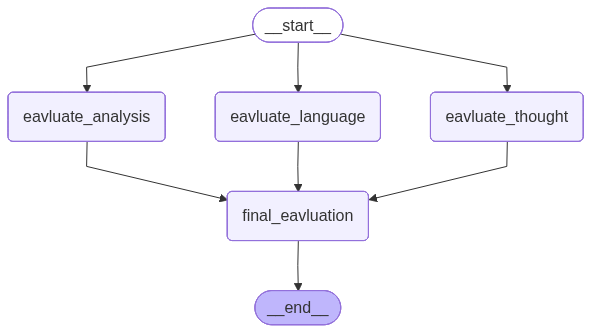

In [64]:
workflow

In [65]:
initial_state = {
    'essay' : essay
}

workflow.invoke(initial_state)

C:\Users\User\AppData\Local\Temp\ipykernel_9876\650810178.py:31: PydanticDeprecatedSince20: The `schema_json` method is deprecated; use `model_json_schema` and json.dumps instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  {schema.schema_json(indent=2)}


{'essay': 'Artificial Intelligence (AI) has rapidly transformed from a futuristic concept into an essential part of everyday life. At its core, AI refers to the ability of machines to perform tasks that typically require human intelligence—such as learning, reasoning, problem-solving, perception, and language understanding. Over the past few decades, advancements in computing power, data availability, and algorithms have enabled AI systems to achieve remarkable capabilities, often surpassing human performance in specific domains.\n\nOne of the most significant impacts of AI is seen in automation. Industries such as manufacturing, logistics, healthcare, and finance now rely heavily on intelligent systems to optimize processes, reduce human error, and improve efficiency. For example, robots assemble products with precision, AI-powered diagnostic tools assist doctors in identifying diseases early, and predictive algorithms help financial institutions detect fraud. These innovations not on